<a href="https://colab.research.google.com/github/snghynn/handsonml/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_Ch7_%EC%95%99%EC%83%81%EB%B8%94%2C_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%9E%98%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch7. 앙상블 학습과 랜덤 포래스트
- 앙상블 학습 : 훈련 세트로부터 다른 서브셋을 만들어 일련의 결정 트리 분류기 훈련시키기
- 예측을 위해 모든 개별 트리의 예측 구하기
- 랜덤 포레스트 : 결정 트리의 앙상

## 7.1 투표 기반 분류기
- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
# 5장의 make_moons 데이터 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [5]:
# 각 분류기의 테스트셋 정확도
from sklearn.metrics import accuracy_score
for clf in (log_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.95
SVC 0.95
VotingClassifier 0.95


> - 투표기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음
- 간접 투표 : 개별 분류기의 예측 평균 내어 확률이 가장 높은 클래스 예측



## 7.2 배깅과 페이스팅
- 배깅(bagging) : 훈련 세트에서 중복을 허용하여 샘플링
- 페이스팅(pasting): 중복을 허용하지 않고 샘플
- 수집 함수
  - 분류: 통계적 최빈갓
  - 회귀: 평균

- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있음
- 수집 함수 통과 시 편향과 분산이 모두 감소

### 7.2.1 사이킷런의 배깅과 페이스팅


In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- bootstraping은 각 예측기가 학습하는 서브셋에 다양성을 증가시킴
- 배깅이 페이스팅보다 편향이 높음
- 다양성을 추가한다는 것 = 상관관계 줄임 : 앙상블의 분산 감소
- 이상적) 교차 검증으로 배깅과 페이스팅을 모두 평가해 더 나은 쪽 선택


### 7.2.2 oob 평가

- 배깅 사용 시 어떤 샘플은 한 예측기를 위해 여러 번 샘플링, 어떤 것은 전혀 선택 X
- BaggingClassifier : 기본값으로 중복 허용(bootstrap=True)
- oob샘플 : 선택되지 않은 나머지 훈련 샘플
  - 예측기가 훈련되는 동안에 사용되지 않음
  - 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음
-  oob_score=True : 훈련 후 자동으로 oob 평가 수행

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9625

oob 평가 결과를 보면 BaggingClassifier는 테스트 세트에서 92.5%정도의 정확도를 얻을 것으로 보임

In [8]:
#테스트 세트에서 정확도 (실제 정확도)
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

- 정확하게 비슷하진 않네,,,


oob_decision_function_: oob 샘플에 대한 결정 함수의 값 확인

In [9]:
bag_clf.oob_decision_function_

array([[0.1       , 0.9       ],
       [0.76683938, 0.23316062],
       [0.38202247, 0.61797753],
       [0.01123596, 0.98876404],
       [0.99456522, 0.00543478],
       [0.94767442, 0.05232558],
       [0.66853933, 0.33146067],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.2460733 , 0.7539267 ],
       [0.91860465, 0.08139535],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.13471503, 0.86528497],
       [0.99418605, 0.00581395],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.33160622, 0.66839378],
       [1.        , 0.        ],
       [0.95263158, 0.04736842],
       [0.        , 1.        ],
       [0.13471503, 0.86528497],
       [0.00531915, 0.99468085],
       [0.08510638, 0.91489362],
       [0.01694915, 0.98305085],
       [0.        , 1.        ],
       [0.88082902, 0.11917098],
       [1.        , 0.        ],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이
- 특성 샘플링: max_features, bootstrap_features
  - 더 다양한 예측기를 만듦
  - 편향을 늘리는 대신 분산을 낮춤
- 랜덤 패치 방식 : 훈련 특성 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

## 7.4 랜덤 포레스트
- bagging을 적용한 결정 트리의 앙상블

In [10]:
# 500개 트리로 이루어진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜포는 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾음
- 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 주입
- 트리를 더욱 다양하게 만듦
- 편향을 손해보는 대신 분산을 낮춤

In [11]:
# BaggingClassifier 사용해 RandomForestClassifier 만들기
bag_clf=BaggingClassifier(DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
                          n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)


### 7.4.1 엑스트라 트리
- 랜덤 포레스트에서 트리 생성 시 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
- randomness 위해 최적의 임곗값 찾기 대신 후보 특성 사용해 무작위로 분할 후 최상의 분할 선택
- 익스트림 랜덤 트리(엑스트라 트리): 극단적으로 무작위한 트리의 랜덤 포레스트
- 편향이 늘어나지만 분산을 낮춤


### 7.4.2 특성 중요도
- 랜포 장점 : 특성의 상대적 중요도를 측정하기 쉬움
- 어느 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인해 특성의 중요도 측정
- 각 노드의 가중치 = 연관된 훈련 샘플 수

In [12]:
# 랜포분류훈련 후 각 특성의 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10433169355229369
sepal width (cm) 0.02230547784287047
petal length (cm) 0.43342125107005675
petal width (cm) 0.4399415775347792


## 7.5 부스팅
- 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블
- 에이다부스트(Adaboost)
- 그레이디언트 부스팅(Gradient Boosting)

### 7.5.1 에이다부스트
- 이전 모델이 과소적합했던 훈련 샘플의 가중치 좊이기
- 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 높임
- 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측
- 그 다음에 가중치를 업데이트
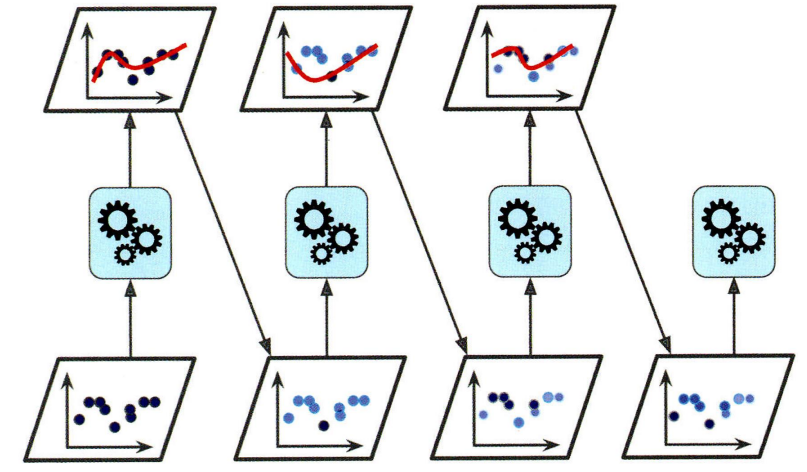

In [13]:
# 결정 트리 기반의 에이다부스트 분류기 훈련
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅
- 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 이전 예측기가 만든 잔여 오차에 새로운 예측기 학습시킴

In [14]:
# 결정 트리를 기반 예측기로 사용하는 회귀 문제
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [15]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [16]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [18]:
import numpy as np

In [19]:
# 테스트셋 생성
X_new = np.array([[0.8]])

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=1)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=1)

> - learning rate: 각 트리의 기여 정도를 조절


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=1)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

In [23]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=1)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=110, random_state=1)

In [24]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=1)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [25]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=1)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [26]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.41666
[1]	validation_0-rmse:0.37704
[2]	validation_0-rmse:0.31248
[3]	validation_0-rmse:0.26831
[4]	validation_0-rmse:0.23834
[5]	validation_0-rmse:0.21807


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:0.21338
[7]	validation_0-rmse:0.21061
[8]	validation_0-rmse:0.20979
[9]	validation_0-rmse:0.21110
[10]	validation_0-rmse:0.20880
[11]	validation_0-rmse:0.20725
[12]	validation_0-rmse:0.20608
[13]	validation_0-rmse:0.20569
[14]	validation_0-rmse:0.20524
[15]	validation_0-rmse:0.20454
[16]	validation_0-rmse:0.20433
[17]	validation_0-rmse:0.20417
[18]	validation_0-rmse:0.20403
[19]	validation_0-rmse:0.20395
[20]	validation_0-rmse:0.20383
[21]	validation_0-rmse:0.20374
[22]	validation_0-rmse:0.20366
[23]	validation_0-rmse:0.20360
[24]	validation_0-rmse:0.20342
[25]	validation_0-rmse:0.20345
[26]	validation_0-rmse:0.20340
[27]	validation_0-rmse:0.20331
[28]	validation_0-rmse:0.20321
[29]	validation_0-rmse:0.20323
[30]	validation_0-rmse:0.20322


## 7.6 스태킹
- 블렌더 훈련: 홀드아웃 세트를 사용하는 것
- 블렌더를 여러 개 훈련시키는 것도 가능함